# MoSeq Pipeline Tutorial

**NOTE: This notebook is a work in progress.**

This notebook provides a tutorial on how to use the MoSeq pipeline to analyze behavioral data. The pipeline is a tool for taking keypoint pose estimations and extracting behavioral syllables.

In [4]:
%load_ext autoreload
%autoreload 2

import spyglass.position.v1 as sgp
from pathlib import Path
import numpy as np

pose_estimation_key = {'nwb_file_name': 'SC100020230912_.nwb',
 'epoch': 9,
 'video_file_num': 14,
 'project_name': 'sideHomeOfficial',
 'dlc_model_name': 'sideHomeOfficial_tutorial_00',
 'dlc_model_params_name': 'default',
 'task_mode': 'trigger'}


(sgp.DLCPoseEstimation.BodyPart & pose_estimation_key).fetch('bodypart')
Path((sgp.DLCProject & pose_estimation_key).fetch1('config_path')).parents[0]/"videos"

[2024-06-12 16:01:13,293][WARNING]: MySQL server has gone away. Reconnecting to the server.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


PosixPath('/nimbus/deeplabcut/projects/sideHomeOfficial-sc_eb-2024-04-16/videos')

### Add Pose data to merge table

In [5]:


# part_name = to_camel_case(self.table_name.split("__")[-1])

# TODO: The next line belongs in a merge table function
# PoseOutput._merge_insert(
#     [insert_key], part_name="DLCPoseEstimation", skip_duplicates=True
# )

### Create Pose Group for training

In [6]:
from spyglass.position.position_merge import PoseOutput
from spyglass.behavior.core import PoseGroup
merge_key = PoseOutput().fetch("merge_id")
PoseGroup().create_group("sb_test_group", merge_key, ['forelimbL', 'forelimbR', 'nose',
       'spine1', 'spine3', 'spine5',
       'tailBase'])

In [ ]:
# test loading data from pose group
# %load_ext autoreload
# %autoreload 2
# from spyglass.behavior.core import PoseGroup
# PoseGroup().fetch_pose_datasets({'group_name': 'sb_test_group'}, format_for_moseq=True)

## Make Moseq Model

In [ ]:
%load_ext autoreload
%autoreload 2
from spyglass.behavior.moseq import MoseqModel, MoseqModelParams, MoseqModelSelection

model_params_name = "sb_testing_kappa4_mini"
params = {}
params['skeleton'] = [['nose','spine1'],
            ['spine1','forelimbL'],
            ['spine1','forelimbR'],
            ['spine1','spine3'],
            ['spine3','spine5'],
            ['spine5','tailBase']]
params['kappa'] = 1e4
params['num_ar_iters'] = 50
params['num_epochs'] = 50
params["anterior_bodyparts"] = ["nose"]
params["posterior_bodyparts"] = ["tailBase"]
# MoseqModelParams().update1({'model_params_name': model_params_name, 'model_params': params},)# skip_duplicates=True)
MoseqModelParams().insert1({'model_params_name': model_params_name, 'model_params': params}, skip_duplicates=True)
MoseqModelParams()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


model_params_name,model_params
sb_testing_kappa-4,=BLOB=
sb_testing_kappa0_mini,=BLOB=
sb_testing_kappa4_mini,=BLOB=


In [ ]:
MoseqModelSelection().insert1({'model_params_name': model_params_name,
                               "pose_group_name":"sb_test_group"}, skip_duplicates=True)

MoseqModelSelection()

pose_group_name,model_params_name
sb_test_group,sb_testing_kappa-4
sb_test_group,sb_testing_kappa0_mini
sb_test_group,sb_testing_kappa4_mini


The directory `/home/sambray/Documents/moseq_test_proj2` already
exists. Use `overwrite=True` or pick a different name


[11:40:06][WARNING] Spyglass: Multiple classes found in stack: {'`moseq_v1`.`__moseq_model`', '`position_v1_dlc_pose_estimation`.`__d_l_c_pose_estimation__body_part`', '`behavior_core_v1`.`pose_group`', '`moseq_v1`.`moseq_model_selection`', '`position_v1_dlc_pose_estimation`.`__d_l_c_pose_estimation`', '`position_merge`.`pose_output`', '`moseq_v1`.`moseq_model_params`'}. Please submit a bug report with the snippet used.
[11:40:06][WARNING] Spyglass: Multiple classes found in stack: {'`moseq_v1`.`__moseq_model`', '`position_v1_dlc_pose_estimation`.`__d_l_c_pose_estimation__body_part`', '`behavior_core_v1`.`pose_group`', '`moseq_v1`.`moseq_model_selection`', '`position_v1_dlc_pose_estimation`.`__d_l_c_pose_estimation`', '`position_merge`.`pose_output`', '`moseq_v1`.`moseq_model_params`'}. Please submit a bug report with the snippet used.
[11:40:06][WARNING] Spyglass: Multiple classes found in stack: {'`moseq_v1`.`__moseq_model`', '`position_v1_dlc_pose_estimation`.`__d_l_c_pose_estimatio

23864
23864
23864
23864
23864
23864
23864
Outputs will be saved to
/home/sambray/Documents/moseq_test_proj2/2024_06_12-11_40_09


 49%|█████████████████▏                 | 25/51 [00:31<00:32,  1.23s/it]

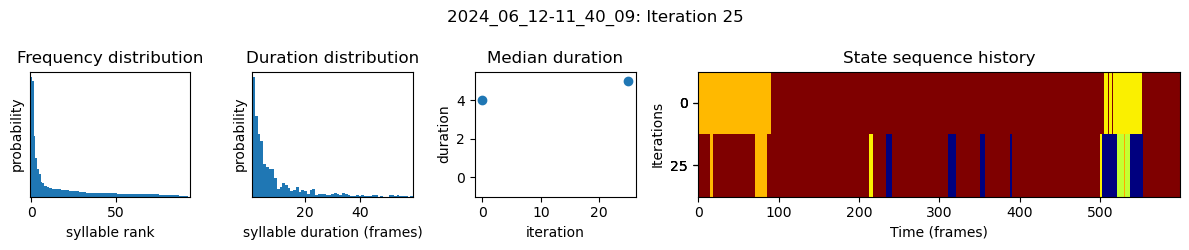

 98%|██████████████████████████████████▎| 50/51 [01:05<00:01,  1.24s/it]

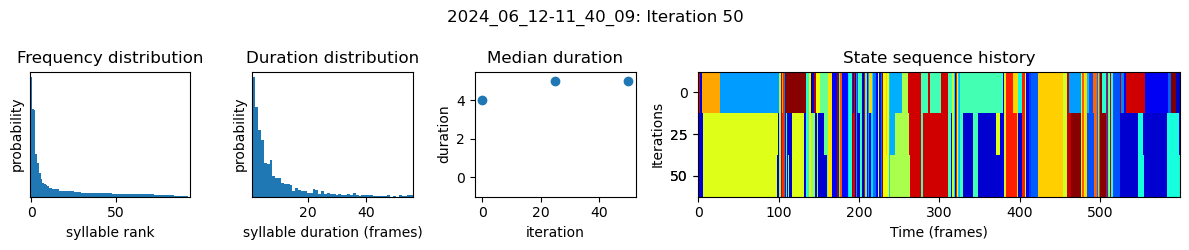

100%|███████████████████████████████████| 51/51 [01:07<00:00,  1.32s/it]


Outputs will be saved to
/home/sambray/Documents/moseq_test_proj2/2024_06_12-11_40_09


 49%|█████████████████▏                 | 25/51 [00:40<00:35,  1.37s/it]

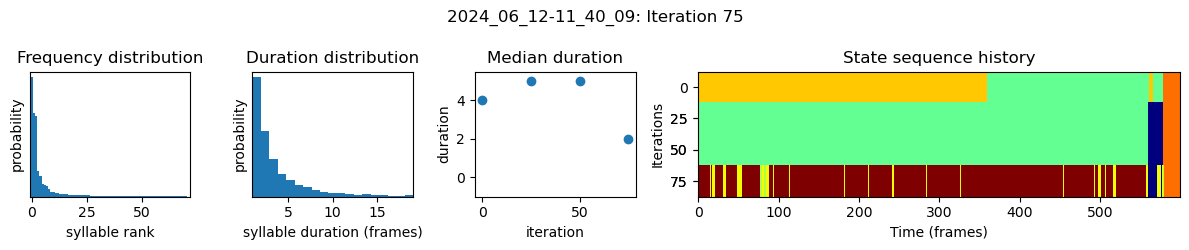

 98%|██████████████████████████████████▎| 50/51 [01:15<00:01,  1.37s/it]

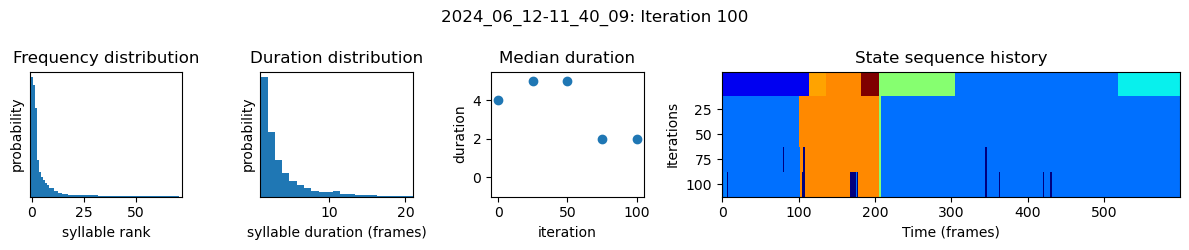

Reindexing: 100%|█████████████| 5/5 [00:00<00:00,  5.27model snapshot/s]


In [ ]:
MoseqModel().populate()

>=90.0% of variance exlained by 6 components.


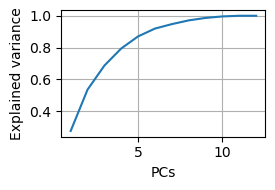

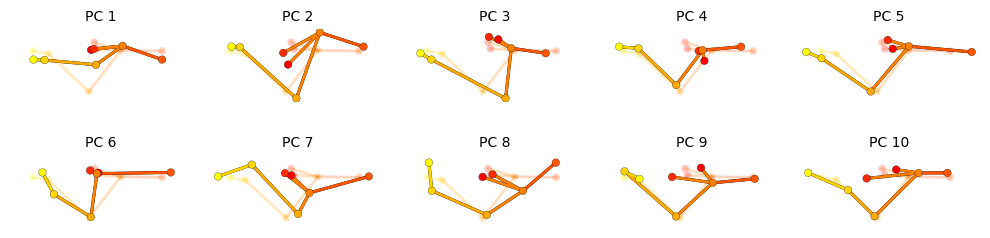

In [ ]:
table = MoseqModel() & {'model_params_name': "sb_testing_kappa4_mini"}
# table.fetch_model()
table.analyze_pca()

In [ ]:
model_key = MoseqModel().fetch1()

In [ ]:
MoseqModelParams.fetch("model_params")[1]#["posterior_bodyparts"]

{'skeleton': [['nose', 'spine1'],
  ['spine1', 'forelimbL'],
  ['spine1', 'forelimbR'],
  ['spine1', 'spine3'],
  ['spine3', 'spine5'],
  ['spine5', 'tailBase']],
 'kappa': 1.0,
 'num_ar_iters': 50,
 'num_epochs': 50,
 'anterior_bodyparts': ['nose'],
 'posterior_bodparts': ['tailBase']}

In [ ]:
# key = MoseqModel().fetch(as_dict=True)[1]
# key["model_name"] = "2024_06_12-11_23_06"

# MoseqModel().update1(key)
MoseqModel()

pose_group_name,model_params_name,project_dir,epochs_trained,model_name
sb_test_group,sb_testing_kappa-4,/home/sambray/Documents/moseq_test_proj,550,
sb_test_group,sb_testing_kappa0_mini,/home/sambray/Documents/moseq_test_proj2,100,2024_06_12-11_23_06


## Run data through the trained model

### Define the entry

In [11]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from spyglass.behavior.moseq import MoseqModel, MoseqModelParams, MoseqModelSelection
from spyglass.behavior.moseq import MoseqSyllableSelection, MoseqSyllable
from spyglass.behavior.core import PoseGroup, format_dataset_for_moseq
from spyglass.position.position_merge import PoseOutput
import keypoint_moseq as kpms

model_key = MoseqModel().fetch("KEY")[-1]
pose_key = PoseGroup().Pose().fetch("pose_merge_id",as_dict=True)[0]
key = {**model_key, **pose_key, "num_iters": 3}
# MoseqSyllableSelection().insert1(key, skip_duplicates=True)
# MoseqSyllableSelection().update1(key)
# MoseqSyllableSelection()

MoseqSyllable().populate(key)
MoseqSyllable()#.drop()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[08:57:59][WARNING] Spyglass: Multiple classes found in stack: {'`position_v1_dlc_pose_estimation`.`__d_l_c_pose_estimation`', '`position_merge`.`pose_output`', '`position_v1_dlc_pose_estimation`.`__d_l_c_pose_estimation__body_part`', '`moseq_v1`.`__moseq_syllable`'}. Please submit a bug report with the snippet used.
[08:57:59][WARNING] Spyglass: Multiple classes found in stack: {'`position_v1_dlc_pose_estimation`.`__d_l_c_pose_estimation`', '`position_merge`.`pose_output`', '`position_v1_dlc_pose_estimation`.`__d_l_c_pose_estimation__body_part`', '`moseq_v1`.`__moseq_syllable`'}. Please submit a bug report with the snippet used.
[08:57:59][WARNING] Spyglass: Multiple classes found in stack: {'`position_v1_dlc_pose_estimation`.`__d_l_c_pose_estimation`', '`position_merge`.`pose_output`', '`position_v1_dlc_pose_estimation`.`__d_l_c_pose_estimation__body_part`', '`moseq_v1`.`__moseq_syllable`'}. Please submit a bug report with the snippet used.
[08:57:59][WARNING] Spyglass: Multiple clas

23864
23864
23864
23864
23864
23864
23864


Applying model: 100%|█████████████████████| 3/3 [00:04<00:00,  1.34s/it]


Saved results to /home/sambray/Documents/moseq_test_proj2/2024_06_12-1
1_40_09/results.h5


/home/sambray/mambaforge-pypy3/envs/spyglass-moseq-1/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning:

Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.

/home/sambray/mambaforge-pypy3/envs/spyglass-moseq-1/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning:

Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.

[08:58:07][INFO] Spyglass: Writing new NWB file SC100020230912_DYUAN3RMWT.nwb
INFO:spyglass:Writing new NWB file SC100020230912_DYUAN3RMWT.nwb


pose_merge_id,pose_group_name,model_params_name,analysis_file_name name of the file,moseq_object_id
8206d0ad-d91b-0e46-649b-7be9c2e8b28c,sb_test_group,sb_testing_kappa4_mini,SC100020230912_DYUAN3RMWT.nwb,771d5bd7-a495-43b6-ae7f-e3e2d8aa08e2


# Extend model training

2024-06-13 12:17:24.739011: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sambray/mambaforge-pypy3/envs/spyglass-moseq-1/lib/python3.9/site-packages/cv2/../../lib64:
2024-06-13 12:17:24.739171: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sambray/mambaforge-pypy3/envs/spyglass-moseq-1/lib/python3.9/site-packages/cv2/../../lib64:
2024-06-13 12:17:24.739182: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2024-06

[2024-06-13 12:17:37,066][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
INFO:datajoint:Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2024-06-13 12:17:37,102][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306
INFO:datajoint:Connected sambray@lmf-db.cin.ucsf.edu:3306


The directory `/home/sambray/Documents/moseq_test_proj2` already
exists. Use `overwrite=True` or pick a different name


[12:17:39][WARNING] Spyglass: Multiple classes found in stack: {'`moseq_v1`.`__moseq_model`', '`behavior_core_v1`.`pose_group`', '`position_v1_dlc_pose_estimation`.`__d_l_c_pose_estimation__body_part`', '`position_merge`.`pose_output`', '`position_v1_dlc_pose_estimation`.`__d_l_c_pose_estimation`'}. Please submit a bug report with the snippet used.
[12:17:40][WARNING] Spyglass: Multiple classes found in stack: {'`moseq_v1`.`__moseq_model`', '`behavior_core_v1`.`pose_group`', '`position_v1_dlc_pose_estimation`.`__d_l_c_pose_estimation__body_part`', '`position_merge`.`pose_output`', '`position_v1_dlc_pose_estimation`.`__d_l_c_pose_estimation`'}. Please submit a bug report with the snippet used.
[12:17:40][WARNING] Spyglass: Multiple classes found in stack: {'`moseq_v1`.`__moseq_model`', '`behavior_core_v1`.`pose_group`', '`position_v1_dlc_pose_estimation`.`__d_l_c_pose_estimation__body_part`', '`position_merge`.`pose_output`', '`position_v1_dlc_pose_estimation`.`__d_l_c_pose_estimation`'

23864
23864
23864
23864
23864
23864
23864
Outputs will be saved to
/home/sambray/Documents/moseq_test_proj2/feeddb9ca2


 25%|████████▍                         | 25/101 [01:09<01:47,  1.41s/it]

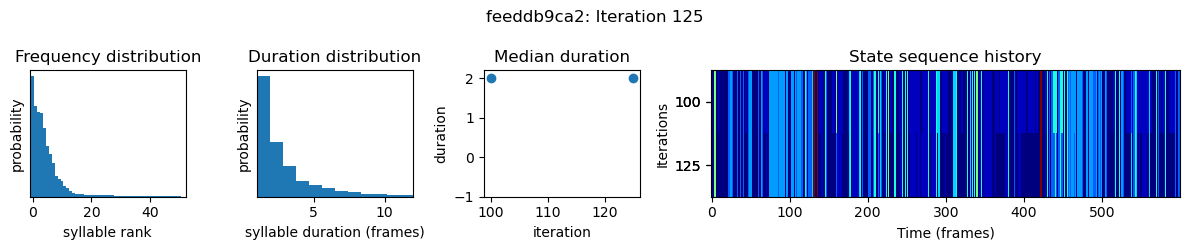

 50%|████████████████▊                 | 50/101 [01:47<01:11,  1.41s/it]

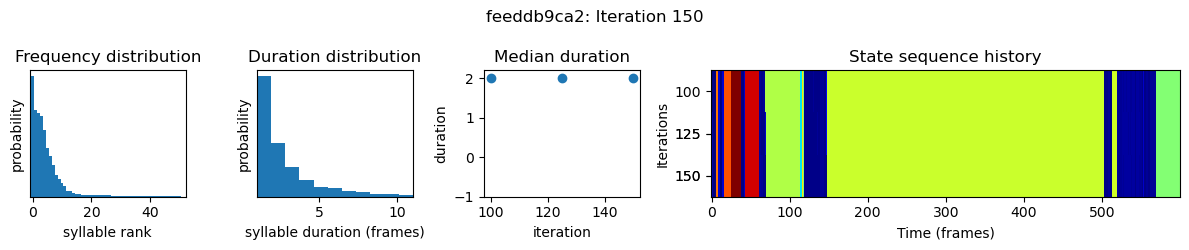

 71%|████████████████████████▏         | 72/101 [02:21<00:56,  1.96s/it]
/home/sambray/mambaforge-pypy3/envs/spyglass-moseq-1/lib/python3.9/site-packages/keypoint_moseq/fitting.py:41: UserWarning:


Early termination of fitting: NaNs encountered
  - 2924 NaNs found in states/h
  - 70210 NaNs found in states/s
  - 20060 NaNs found in states/v
  - 29240 NaNs found in states/x

For additional information, see https://keypoint-moseq.readthedocs.io/en/latest/troubleshooting.html#nans-during-fitting

Reindexing: 100%|█████████████| 3/3 [00:00<00:00,  5.61model snapshot/s]


In [1]:
%load_ext autoreload
%autoreload 2
from spyglass.behavior.moseq import MoseqModel, MoseqModelSelection, MoseqModelParams

model_key = (MoseqModel() & {"model_params_name": "sb_testing_kappa4_mini"}).fetch1("KEY")

extension_params = MoseqModelParams().make_training_extension_params(model_key,100,skip_duplicates=True)
extension_params
model_key
new_model_key = {"model_params_name":extension_params["model_params_name"],
                    "pose_group_name":model_key["pose_group_name"]}
MoseqModelSelection().insert1(new_model_key,skip_duplicates=True)
MoseqModel().populate(new_model_key)

In [25]:
from spyglass.behavior.moseq import MoseqSyllableSelection, MoseqSyllable
MoseqModel() & new_model_key
selection_key = {"pose_merge_id":"8206d0ad-d91b-0e46-649b-7be9c2e8b28c",
                 "num_iters":30,
                 **new_model_key}
MoseqSyllableSelection().insert1(selection_key,skip_duplicates=True)
MoseqSyllable().populate(selection_key)


[11:38:51][WARNING] Spyglass: Multiple classes found in stack: {'`moseq_v1`.`__moseq_syllable`', '`moseq_v1`.`moseq_model_params`', '`position_v1_dlc_pose_estimation`.`__d_l_c_pose_estimation__body_part`', '`moseq_v1`.`__moseq_model`', '`moseq_v1`.`moseq_syllable_selection`', '`position_merge`.`pose_output`', '`position_v1_dlc_pose_estimation`.`__d_l_c_pose_estimation`'}. Please submit a bug report with the snippet used.
[11:38:51][WARNING] Spyglass: Multiple classes found in stack: {'`moseq_v1`.`__moseq_syllable`', '`moseq_v1`.`moseq_model_params`', '`position_v1_dlc_pose_estimation`.`__d_l_c_pose_estimation__body_part`', '`moseq_v1`.`__moseq_model`', '`moseq_v1`.`moseq_syllable_selection`', '`position_merge`.`pose_output`', '`position_v1_dlc_pose_estimation`.`__d_l_c_pose_estimation`'}. Please submit a bug report with the snippet used.
[11:38:51][WARNING] Spyglass: Multiple classes found in stack: {'`moseq_v1`.`__moseq_syllable`', '`moseq_v1`.`moseq_model_params`', '`position_v1_dlc_

23864
23864
23864
23864
23864
23864
23864


Applying model:  80%|███████████████▏   | 24/30 [00:34<00:08,  1.43s/it]
/home/sambray/mambaforge-pypy3/envs/spyglass-moseq-1/lib/python3.9/site-packages/keypoint_moseq/fitting.py:41: UserWarning:


Early termination of fitting: NaNs encountered
  - 2686 NaNs found in states/h
  - 70210 NaNs found in states/s
  - 20060 NaNs found in states/v
  - 26860 NaNs found in states/x

For additional information, see https://keypoint-moseq.readthedocs.io/en/latest/troubleshooting.html#nans-during-fitting



Saved results to /home/sambray/Documents/moseq_test_proj2/2024_06_12-1
1_40_09/results.h5


/home/sambray/mambaforge-pypy3/envs/spyglass-moseq-1/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning:

Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.

/home/sambray/mambaforge-pypy3/envs/spyglass-moseq-1/lib/python3.9/site-packages/hdmf/utils.py:668: UserWarning:

Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.

[11:39:35][INFO] Spyglass: Writing new NWB file SC100020230912_WUAQVSMOGM.nwb
INFO:spyglass:Writing new NWB file SC100020230912_WUAQVSMOGM.nwb


In [2]:
# (MoseqSyllableSelection & selection_key).delete(selection_key)
(MoseqModel() & new_model_key)#.delete(new_model_key)

pose_group_name,model_params_name,project_dir,epochs_trained,model_name
sb_test_group,sb_test_groupsb_testing_kappa4_mini_extension001,/home/sambray/Documents/moseq_test_proj2,200,feeddb9ca2


In [46]:
results = (MoseqSyllable & selection_key).fetch1_dataframe()

[12:06:55][WARNING] Spyglass: Multiple classes found in stack: {'`moseq_v1`.`__moseq_syllable`', '`moseq_v1`.`moseq_model_params`', '`moseq_v1`.`__moseq_model`', '`moseq_v1`.`moseq_syllable_selection`'}. Please submit a bug report with the snippet used.


In [29]:
results

,syllable,centroid x,centroid y,heading,latent_state 0,latent_state 1,latent_state 2,latent_state 3,latent_state 4,latent_state 5,latent_state 6,latent_state 7,latent_state 8,latent_state 9
time,,,,,,,,,,,,,,
1.694621e+09,1,8050.8443,3697.3771,0.3761,0.3156,-5.6379,2.3612,0.8233,2.4966,0.5598,4.4412,-1.9404,-3.8596,5.5380
1.694621e+09,1,8052.6329,3697.3823,-0.2097,0.0632,2.0453,-2.6209,10.9164,4.1568,1.4786,-5.3021,4.5947,-0.8840,0.6200
1.694621e+09,1,8054.4642,3697.6510,-0.2156,-0.7071,-0.9933,0.6741,5.0110,3.8812,-0.4811,-2.2053,-0.0753,3.2583,2.5587
1.694621e+09,1,8055.3521,3698.3835,-0.2828,-0.6419,-1.2613,1.0131,3.8245,4.0471,-0.4889,-1.6345,-1.4950,4.3711,4.1248
1.694621e+09,0,8056.8049,3697.1540,-0.3571,-0.6830,-1.3918,0.9221,3.6734,3.8062,-0.3035,-1.6206,-1.7340,4.3643,4.2387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.694622e+09,1,7585.0887,4034.5034,2.7263,0.4718,-0.9038,0.1101,0.9661,-1.8075,0.7622,-1.1263,-0.4601,-2.2455,-5.3826
1.694622e+09,4,7596.1810,4036.9217,2.7924,0.5502,-0.8207,0.1604,1.1446,-1.7895,0.8248,-0.7973,-0.8894,-0.8934,-3.6218
1.694622e+09,1,7608.0722,4039.9465,2.7196,0.5995,-0.6641,0.1043,1.1654,-1.9216,0.8223,-0.4043,-0.8952,-0.1921,-2.8618


In [45]:
import hashlib
key_string = "_".join(model_key.values())
hashlib.sha1(key_string.encode("utf-8")).hexdigest()[:10]

'439ee83193'